In [79]:
import nltk as nltk
import pandas as pd
import numpy as np
import re
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import math
from nltk.corpus import stopwords
import string
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora, models
import time
import pyLDAvis.gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
!pip install -U gensim

     |████████████████████████████████| 24.2MB 9.1MB/s eta 0:00:01
     |████████████████████████████████| 122kB 33.7MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=ba1fc8379361228181bff0ac8acf3460b25069ad403ea911e181b86034a2ecba
  Stored in directory: /Users/mohammedhussain/Library/Caches/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open


In [56]:
!pip install -U pyLDAvis

     |████████████████████████████████| 1.6MB 3.9MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=08c261c3ee4db716d22456c29c92b276e4ca0dcef94218a9bcfca6e1a0b3c761
  Stored in directory: /Users/mohammedhussain/Library/Caches/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [3]:
df = pd.read_pickle('webhose_cat.pkl')

In [4]:
df.head()

,crawled,language,text,title,url
0,2018-01-30T18:28:45.012+02:00,english,Avery Dennison's (AVY) Q4 results are likely t...,IRobot downgraded to neutral from buy at Sidot...,http://omgili.com/ri/.wHSUbtEfZQRfU.5KUm1RkeXy...
1,2018-01-30T18:29:07.001+02:00,french,"1m95, c’est trop grand. Et sa stature, Bertran...","""Bertrand Zibi Abeghe, encore prisonnier, et t...",http://omgili.com/ri/.wHSUbtEfZTpzFtnXyQJIwJ.j...
2,2018-01-30T18:29:40.000+02:00,english,Tuggers and Topper Industrial Carts Help Trans...,Tuggers and Topper Industrial Carts Help Trans...,http://omgili.com/ri/jHIAmI4hxg.zDiulpymXqU_n4...
3,2018-01-30T18:30:05.007+02:00,english,Currently adding the following games:\n100 (by...,,http://omgili.com/ri/.0rSU5LtMgyggHgoOVy9TMDWT...
4,2018-01-30T18:30:05.013+02:00,english,Quote: : » Currently adding the following game...,,http://omgili.com/ri/.0rSU5LtMgyggHgoOVy9TMDWT...


In [5]:
pd.set_option('display.max_colwidth', 100)
df[['text', 'title']].head()

,text,title
0,Avery Dennison's (AVY) Q4 results are likely to gain on the back of solid momentum in its segmen...,IRobot downgraded to neutral from buy at Sidoti & Co.
1,"1m95, c’est trop grand. Et sa stature, Bertrand Zibi Abeghe en paie le prix. Dans sa cellule de ...","""Bertrand Zibi Abeghe, encore prisonnier, et torturé"", un récit de Jeanne Farge"
2,Tuggers and Topper Industrial Carts Help Transport Materials Between Manufacturing Plants and Wa...,Tuggers and Topper Industrial Carts Help Transport Materials Between Manufacturing Plants and Wa...
3,Currently adding the following games:\n100 (by everythingstaken) 100 Free Beetles 2000:1: A Spac...,
4,Quote: : » Currently adding the following games:\n100 (by everythingstaken) 100 Free Beetles 200...,


In [6]:
df.shape

(100, 5)

# Cleaning the Data

In [9]:
# Filtering non-English news articles
df = df[df['language']=='english'].reset_index(drop=True)

In [10]:
# Removing special characters to avoid problems with analysis
df['text_clean'] = df['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

In [12]:
pd.set_option('display.max_colwidth', 100)
df[['text', 'text_clean']].head()

,text,text_clean
0,Avery Dennison's (AVY) Q4 results are likely to gain on the back of solid momentum in its segmen...,"Avery Dennisons AVY Q4 results are likely to gain on the back of solid momentum in its segments,..."
1,Tuggers and Topper Industrial Carts Help Transport Materials Between Manufacturing Plants and Wa...,Tuggers and Topper Industrial Carts Help Transport Materials Between Manufacturing Plants and Wa...
2,Currently adding the following games:\n100 (by everythingstaken) 100 Free Beetles 2000:1: A Spac...,Currently adding the following games:100 by everythingstaken 100 Free Beetles 2000:1: A Space Fe...
3,Quote: : » Currently adding the following games:\n100 (by everythingstaken) 100 Free Beetles 200...,Quote: : Currently adding the following games:100 by everythingstaken 100 Free Beetles 2000:1: ...
4,Quote: : » Currently adding the following games:\n100 (by everythingstaken) 100 Free Beetles 200...,Quote: : Currently adding the following games:100 by everythingstaken 100 Free Beetles 2000:1: ...


# Topic Modelling

In [13]:
# Using TextBlob functionality to create TF-IDF function for our news articles 

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)
# tf(word, blob) computes "term frequency" which is the number of times a word appears in a document blob, 
# normalized by dividing by the total number of words in blob. We use TextBlob for breaking up the text into words 
# and getting the word counts.


def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)
# n_containing(word, bloblist) returns the number of documents containing word. 
# A generator expression is passed to the sum() function.


def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))
# idf(word, bloblist) computes "inverse document frequency" which measures how common a word is 
# among all documents in bloblist. The more common a word is, the lower its idf. 
# We take the ratio of the total number of documents to the number of documents containing word, 
# then take the log of that. Add 1 to the divisor to prevent division by zero


def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)
# tfidf(word, blob, bloblist) computes the TF-IDF score. It is simply the product of tf and idf.

In [14]:
bloblist = []
del bloblist[:]

for i in range(0,len(df)):
    bloblist.append(TextBlob(df['text_clean'].iloc[i]))
    
len(bloblist)

95

In [43]:
for i, blob in enumerate(bloblist):
# Print top 5 values
    if i == 5:
        break
    print("Top words in news article {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:10]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in news article 1
	Word: ET, TF-IDF: 0.11986
	Word: On, TF-IDF: 0.0776
	Word: a.m, TF-IDF: 0.06613
	Word: Jan, TF-IDF: 0.06186
	Word: p.m, TF-IDF: 0.05373
	Word: Zacks.com, TF-IDF: 0.0508
	Word: 2018, TF-IDF: 0.03319
	Word: Oct, TF-IDF: 0.03306
	Word: 2017, TF-IDF: 0.0308
	Word: iRobot, TF-IDF: 0.02893
Top words in news article 2
	Word: Carts, TF-IDF: 0.09488
	Word: carts, TF-IDF: 0.08698
	Word: Topper, TF-IDF: 0.07248
	Word: To, TF-IDF: 0.06167
	Word: Industrial, TF-IDF: 0.04261
	Word: industrial, TF-IDF: 0.04261
	Word: operators, TF-IDF: 0.02899
	Word: handling, TF-IDF: 0.02696
	Word: Warehouses, TF-IDF: 0.02372
	Word: Transport, TF-IDF: 0.02175
Top words in news article 3
	Word: THE, TF-IDF: 0.14393
	Word: OF, TF-IDF: 0.0455
	Word: And, TF-IDF: 0.02571
	Word: Space, TF-IDF: 0.0195
	Word: Tower, TF-IDF: 0.0195
	Word: Super, TF-IDF: 0.01829
	Word: 2, TF-IDF: 0.01822
	Word: The, TF-IDF: 0.01765
	Word: Last, TF-IDF: 0.01727
	Word: adding, TF-IDF: 0.01398
Top words in news arti

# LDA(Latent Direchlet Allocation) to the articles

In [22]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

df_clean = [clean(doc).split() for doc in df['text_clean'].to_list()]     

In [23]:
len(df_clean)

95

In [30]:
type(df_clean)

list

In [37]:
print(df_clean[:1])

[['avery', 'dennisons', 'avy', 'q4', 'result', 'likely', 'gain', 'back', 'solid', 'momentum', 'segment', 'focus', 'productivity', 'acquisition', 'cost', 'control', 'effort', 'jan', '30', '2018', '340', 'am', 'et', 'zackscom', '5', 'strong', 'stock', 'company', 'still', 'led', 'founder', 'day', 'executive', 'transition', 'often', 'appease', 'shareholder', 'especially', 'tough', 'timeseven', 'mean', 'axing', 'company', 'founder', 'top', 'that', 'ceo', 'jump', 'company', 'company', 'making', 'increasingly', 'rare', 'see', 'founder', 'successfully', 'lead', 'startup', 'publicly', 'traded', 'giant', 'keep', 'top', 'gig', 'jan', '25', '2018', '1142', 'am', 'et', 'zackscom', 'rockwell', 'automation', 'rok', 'expects', 'benefit', 'expanded', 'product', 'offering', 'strong', 'customer', 'relationship', 'strategic', 'focus', 'connected', 'enterprise', 'jan', '24', '2018', '323', 'pm', 'et', 'zackscom', 'pentairs', 'pnr', 'q4', 'result', 'likely', 'gain', 'residential', 'commercial', 'sector', 'd

In [42]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(df_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df_clean]

## 3 Topic model

In [51]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

warnings.simplefilter('ignore')
# Running and Trainign LDA model on the document term matrix.
%time ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)


CPU times: user 32.2 s, sys: 214 ms, total: 32.4 s
Wall time: 8.18 s


In [52]:
print(*ldamodel.print_topics(num_topics=3, num_words=3), sep='\n')

(0, '0.009*"jan" + 0.007*"sphere" + 0.007*"inc"')
(1, '0.018*"market" + 0.007*"industry" + 0.006*"report"')
(2, '0.008*"tax" + 0.007*"company" + 0.007*"plant"')


In [58]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

The Three topic model seems like a good start with the topic modelling using LDA. It looks like a well interpretable model and it was able to bring some level of structure to the unstructured articles' textual data and also helps in summarizing the topics a little bit.

Topic 1 seems to be about Amazon and Topic 2 seems to be about caterpillar market report. Topic 3 seems to be about taxes and overall market situation.

The 3 topic model seems to cover only a few topics and they are not totally distinct in terms of context and topics.
The bubbles dont seem to overlap which is a good sign that there is not much duplication in terms of topics. But it would be worth to keep exploring further with more topic models using LDA.

In [47]:
print(*ldamodel.print_topics(num_topics=3, num_words=5), sep='\n')

(0, '0.006*"median" + 0.005*"city" + 0.005*"estimate" + 0.005*"university" + 0.005*"company"')
(1, '0.012*"tax" + 0.010*"plant" + 0.009*"u" + 0.008*"market" + 0.006*"case"')
(2, '0.009*"jan" + 0.008*"market" + 0.007*"share" + 0.007*"caterpillar" + 0.007*"company"')


In [48]:
print(*ldamodel.print_topics(num_topics=3, num_words=7), sep='\n')

(0, '0.006*"median" + 0.005*"city" + 0.005*"estimate" + 0.005*"university" + 0.005*"company" + 0.005*"2017" + 0.004*"new"')
(1, '0.012*"tax" + 0.010*"plant" + 0.009*"u" + 0.008*"market" + 0.006*"case" + 0.005*"china" + 0.005*"repatriation"')
(2, '0.009*"jan" + 0.008*"market" + 0.007*"share" + 0.007*"caterpillar" + 0.007*"company" + 0.006*"inc" + 0.005*"2018"')


In [49]:
print(*ldamodel.print_topics(num_topics=3, num_words=9), sep='\n')

(0, '0.006*"median" + 0.005*"city" + 0.005*"estimate" + 0.005*"university" + 0.005*"company" + 0.005*"2017" + 0.004*"new" + 0.004*"state" + 0.004*"town"')
(1, '0.012*"tax" + 0.010*"plant" + 0.009*"u" + 0.008*"market" + 0.006*"case" + 0.005*"china" + 0.005*"repatriation" + 0.004*"year" + 0.004*"one"')
(2, '0.009*"jan" + 0.008*"market" + 0.007*"share" + 0.007*"caterpillar" + 0.007*"company" + 0.006*"inc" + 0.005*"2018" + 0.005*"sphere" + 0.005*"product"')


# 5 Topic Model

In [59]:
%time ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50) #5 topics
print(*ldamodel.print_topics(num_topics=5, num_words=3), sep='\n')

CPU times: user 32.1 s, sys: 223 ms, total: 32.3 s
Wall time: 8.18 s
(0, '0.009*"caterpillar" + 0.009*"median" + 0.008*"estimate" + 0.008*"city" + 0.008*"share"')
(1, '0.023*"market" + 0.008*"company" + 0.007*"industry" + 0.006*"report" + 0.006*"new"')
(2, '0.012*"tax" + 0.009*"u" + 0.006*"inc" + 0.005*"china" + 0.005*"year"')
(3, '0.018*"plant" + 0.011*"jan" + 0.009*"sphere" + 0.009*"amazon" + 0.009*"case"')
(4, '0.007*"house" + 0.005*"caterpillar" + 0.004*"one" + 0.003*"like" + 0.003*"canna"')


In [ ]:
print(*ldamodel.print_topics(num_topics=5, num_words=5), sep='\n')

In [ ]:
print(*ldamodel.print_topics(num_topics=5, num_words=7), sep='\n')

In [ ]:
print(*ldamodel.print_topics(num_topics=5, num_words=9), sep='\n')

In [ ]:
print(*ldamodel.print_topics(num_topics=5, num_words=10), sep='\n')

In [60]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

We still do not see any overalp between the bubbles or clusters which indicates there is not much duplication. This model has more number of topics and the results are reasonably interpretable as well. The five topic model is still not complex and its fairly a simple one.

# Ten Topic Model

In [63]:
%time ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)
print(*ldamodel.print_topics(num_topics=10, num_words=10), sep='\n')

CPU times: user 33.2 s, sys: 258 ms, total: 33.4 s
Wall time: 8.47 s
(0, '0.031*"plant" + 0.019*"case" + 0.011*"wardian" + 0.010*"terrarium" + 0.009*"care" + 0.007*"soil" + 0.007*"water" + 0.006*"glass" + 0.005*"box" + 0.005*"one"')
(1, '0.016*"inc" + 0.012*"jan" + 0.007*"corp" + 0.006*"dec" + 0.005*"oct" + 0.005*"nov" + 0.005*"robot" + 0.005*"bucket" + 0.004*"support" + 0.004*"etf"')
(2, '0.022*"tax" + 0.015*"u" + 0.009*"china" + 0.008*"repatriation" + 0.006*"would" + 0.006*"profit" + 0.006*"foreign" + 0.006*"year" + 0.006*"say" + 0.005*"company"')
(3, '0.038*"market" + 0.012*"report" + 0.011*"industry" + 0.009*"state" + 0.009*"analysis" + 0.008*"united" + 0.008*"also" + 0.007*"construction" + 0.007*"application" + 0.007*"product"')
(4, '0.022*"market" + 0.012*"jan" + 0.011*"share" + 0.010*"blade" + 0.009*"operation" + 0.008*"industry" + 0.008*"new" + 0.007*"pusher" + 0.007*"global" + 0.007*"skid"')
(5, '0.007*"caterpillar" + 0.004*"email" + 0.004*"source" + 0.003*"part" + 0.003*"perf

In [62]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

The ten topic model seems to be little complex compared to the precedding ones that we have discussed so far. We also a minor level of duplication but thats not significant enough.

# 15 - Topic Model

In [66]:
%time ldamodel = Lda(doc_term_matrix, num_topics=15, id2word = dictionary, passes=50)
print(*ldamodel.print_topics(num_topics=15, num_words=5), sep='\n')

CPU times: user 34.8 s, sys: 309 ms, total: 35.1 s
Wall time: 8.95 s
(0, '0.016*"truck" + 0.013*"excavator" + 0.012*"fit" + 0.011*"machine" + 0.011*"sold"')
(1, '0.012*"company" + 0.010*"iot" + 0.008*"health" + 0.007*"new" + 0.006*"mnubo"')
(2, '0.017*"median" + 0.017*"city" + 0.016*"estimate" + 0.015*"university" + 0.014*"2017"')
(3, '0.019*"house" + 0.013*"forklift" + 0.007*"like" + 0.006*"accounting" + 0.005*"one"')
(4, '0.008*"automation" + 0.007*"export" + 0.007*"transportation" + 0.007*"skill" + 0.006*"execution"')
(5, '0.007*"video" + 0.005*"also" + 0.005*"self" + 0.005*"process" + 0.004*"employee"')
(6, '0.025*"blade" + 0.020*"pusher" + 0.017*"snow" + 0.017*"skid" + 0.016*"rubber"')
(7, '0.014*"operation" + 0.013*"share" + 0.012*"jan" + 0.007*"new" + 0.006*"company"')
(8, '0.016*"cart" + 0.012*"topper" + 0.011*"industrial" + 0.008*"grader" + 0.008*"material"')
(9, '0.052*"market" + 0.016*"report" + 0.015*"industry" + 0.011*"analysis" + 0.010*"growth"')
(10, '0.007*"work" + 0.00

In [67]:
print(*ldamodel.print_topics(num_topics=15, num_words=7), sep='\n')

(0, '0.016*"truck" + 0.013*"excavator" + 0.012*"fit" + 0.011*"machine" + 0.011*"sold" + 0.010*"bulldozer" + 0.010*"thumb"')
(1, '0.012*"company" + 0.010*"iot" + 0.008*"health" + 0.007*"new" + 0.006*"mnubo" + 0.006*"data" + 0.006*"robot"')
(2, '0.017*"median" + 0.017*"city" + 0.016*"estimate" + 0.015*"university" + 0.014*"2017" + 0.012*"town" + 0.011*"state"')
(3, '0.019*"house" + 0.013*"forklift" + 0.007*"like" + 0.006*"accounting" + 0.005*"one" + 0.005*"project" + 0.005*"home"')
(4, '0.008*"automation" + 0.007*"export" + 0.007*"transportation" + 0.007*"skill" + 0.006*"execution" + 0.006*"hp" + 0.006*"individual"')
(5, '0.007*"video" + 0.005*"also" + 0.005*"self" + 0.005*"process" + 0.004*"employee" + 0.004*"song" + 0.004*"requirement"')
(6, '0.025*"blade" + 0.020*"pusher" + 0.017*"snow" + 0.017*"skid" + 0.016*"rubber" + 0.014*"panel" + 0.014*"end"')
(7, '0.014*"operation" + 0.013*"share" + 0.012*"jan" + 0.007*"new" + 0.006*"company" + 0.006*"post" + 0.005*"26"')
(8, '0.016*"cart" + 0.

In [68]:
print(*ldamodel.print_topics(num_topics=15, num_words=10), sep='\n')

(0, '0.016*"truck" + 0.013*"excavator" + 0.012*"fit" + 0.011*"machine" + 0.011*"sold" + 0.010*"bulldozer" + 0.010*"thumb" + 0.009*"backhoe" + 0.009*"john" + 0.009*"deere"')
(1, '0.012*"company" + 0.010*"iot" + 0.008*"health" + 0.007*"new" + 0.006*"mnubo" + 0.006*"data" + 0.006*"robot" + 0.005*"one" + 0.005*"employee" + 0.005*"care"')
(2, '0.017*"median" + 0.017*"city" + 0.016*"estimate" + 0.015*"university" + 0.014*"2017" + 0.012*"town" + 0.011*"state" + 0.009*"zillow" + 0.009*"major" + 0.008*"home"')
(3, '0.019*"house" + 0.013*"forklift" + 0.007*"like" + 0.006*"accounting" + 0.005*"one" + 0.005*"project" + 0.005*"home" + 0.005*"architect" + 0.004*"tire" + 0.004*"used"')
(4, '0.008*"automation" + 0.007*"export" + 0.007*"transportation" + 0.007*"skill" + 0.006*"execution" + 0.006*"hp" + 0.006*"testing" + 0.006*"individual" + 0.005*"good" + 0.005*"including"')
(5, '0.007*"video" + 0.005*"also" + 0.005*"self" + 0.005*"process" + 0.004*"employee" + 0.004*"song" + 0.004*"requirement" + 0.00

In [69]:
print(*ldamodel.print_topics(num_topics=15, num_words=12), sep='\n')

(0, '0.016*"truck" + 0.013*"excavator" + 0.012*"fit" + 0.011*"machine" + 0.011*"sold" + 0.010*"bulldozer" + 0.010*"thumb" + 0.009*"backhoe" + 0.009*"john" + 0.009*"deere" + 0.009*"lb" + 0.008*"bucket"')
(1, '0.012*"company" + 0.010*"iot" + 0.008*"health" + 0.007*"new" + 0.006*"mnubo" + 0.006*"data" + 0.006*"robot" + 0.005*"one" + 0.005*"employee" + 0.005*"care" + 0.005*"hsb" + 0.004*"system"')
(2, '0.017*"median" + 0.017*"city" + 0.016*"estimate" + 0.015*"university" + 0.014*"2017" + 0.012*"town" + 0.011*"state" + 0.009*"zillow" + 0.009*"major" + 0.008*"home" + 0.008*"college" + 0.007*"live"')
(3, '0.019*"house" + 0.013*"forklift" + 0.007*"like" + 0.006*"accounting" + 0.005*"one" + 0.005*"project" + 0.005*"home" + 0.005*"architect" + 0.004*"tire" + 0.004*"used" + 0.004*"design" + 0.004*"caterpillar"')
(4, '0.008*"automation" + 0.007*"export" + 0.007*"transportation" + 0.007*"skill" + 0.006*"execution" + 0.006*"hp" + 0.006*"testing" + 0.006*"individual" + 0.005*"good" + 0.005*"including

In [70]:
print(*ldamodel.print_topics(num_topics=15, num_words=15), sep='\n')

(0, '0.016*"truck" + 0.013*"excavator" + 0.012*"fit" + 0.011*"machine" + 0.011*"sold" + 0.010*"thumb" + 0.010*"bulldozer" + 0.009*"backhoe" + 0.009*"john" + 0.009*"deere" + 0.009*"lb" + 0.008*"bucket" + 0.006*"caterpillar" + 0.006*"trackhoe" + 0.006*"ripper"')
(1, '0.012*"company" + 0.010*"iot" + 0.008*"health" + 0.007*"new" + 0.006*"mnubo" + 0.006*"data" + 0.006*"robot" + 0.005*"one" + 0.005*"employee" + 0.005*"care" + 0.005*"hsb" + 0.004*"system" + 0.004*"cost" + 0.004*"product" + 0.004*"munich"')
(2, '0.017*"median" + 0.017*"city" + 0.016*"estimate" + 0.015*"university" + 0.014*"2017" + 0.012*"town" + 0.011*"state" + 0.009*"zillow" + 0.009*"major" + 0.008*"home" + 0.008*"college" + 0.007*"live" + 0.007*"population" + 0.007*"census" + 0.007*"bureau"')
(3, '0.019*"house" + 0.013*"forklift" + 0.007*"like" + 0.006*"accounting" + 0.005*"one" + 0.005*"project" + 0.005*"home" + 0.005*"architect" + 0.004*"tire" + 0.004*"used" + 0.004*"design" + 0.004*"caterpillar" + 0.004*"manufacturing" + 

In [65]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

The 15 - topic model is the most complex model out of all the models that we have seen so far. We also see some bubbles or clusters starting to overalap which means that there is significant level of duplication. Its really hard to interpret the results or overall topics because the model has already become too complex and little disorganized in terms of placement of certain terms or topics in different bubbles or clusters.

So our job now is to find the ideal model that lies somewhere between the 10-topic model and 15-topic model.

We will use the technique of coherence scores to find the perfect model for us that has little or no duplication at all with all relevant topics.

# Evaluation of Topic Modeling: Topic Coherence

The technique of coherence scores is the perfect tool for us so that we can evaluaate all of our topic models and choose the best one which does the trade-off between interpretability and complexity in the best possible way. The coherence scores approach calculates the probablities that the words with special relevance within an article get an assigned topic considering that the article already has those words contained in it. We want the topics to be relevant with no duplication or overlap between the bubbles or clusters. We also want the topics to be dominated only by a few special relevant words so that the topics or results could be easily be interpreted. We would be aiming for high coherence but we should also be balancing the trade-off between complexity and interpretibility making sure that high coherence doesnt lead to to the increase in the consumption of computational resources or high complexity.

Reference : https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

We will now generate multiple LDA models from 1-20 range with wide range of topics and select the best performing LDA model.

In [74]:
models_lda = []
max_limit_topics = 20
ideal_no_of_topics = []

for i in range(1, max_limit_topics):
    ideal_no_of_topics.append(i+1)
    %time lda_model = LdaMulticore(doc_term_matrix, num_topics=i+1, id2word = dictionary, passes=50)
    models_lda.append(lda_model)

CPU times: user 43.3 s, sys: 1.66 s, total: 45 s
Wall time: 12.9 s
CPU times: user 42.2 s, sys: 1.51 s, total: 43.8 s
Wall time: 12.2 s
CPU times: user 42.1 s, sys: 1.43 s, total: 43.5 s
Wall time: 12 s
CPU times: user 41.8 s, sys: 1.47 s, total: 43.3 s
Wall time: 12.1 s
CPU times: user 41.4 s, sys: 1.32 s, total: 42.7 s
Wall time: 11.7 s
CPU times: user 41 s, sys: 1.36 s, total: 42.4 s
Wall time: 11.7 s
CPU times: user 40.6 s, sys: 1.62 s, total: 42.2 s
Wall time: 12 s
CPU times: user 42 s, sys: 1.41 s, total: 43.4 s
Wall time: 11.9 s
CPU times: user 42 s, sys: 1.36 s, total: 43.4 s
Wall time: 11.9 s
CPU times: user 42.1 s, sys: 1.41 s, total: 43.5 s
Wall time: 12 s
CPU times: user 42.7 s, sys: 1.38 s, total: 44.1 s
Wall time: 12.2 s
CPU times: user 42.7 s, sys: 1.52 s, total: 44.2 s
Wall time: 12.3 s
CPU times: user 43.5 s, sys: 1.31 s, total: 44.8 s
Wall time: 12.3 s
CPU times: user 43.3 s, sys: 1.39 s, total: 44.7 s
Wall time: 12.4 s
CPU times: user 43.3 s, sys: 1.45 s, total: 44.8

In [78]:
coherence_scores = []

for i in models_lda:
    coherence_model = CoherenceModel(model=i, texts=df_clean, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

[Text(0, 0.5, 'Coherence Score'), Text(0.5, 0, 'Total Number of Topics')]

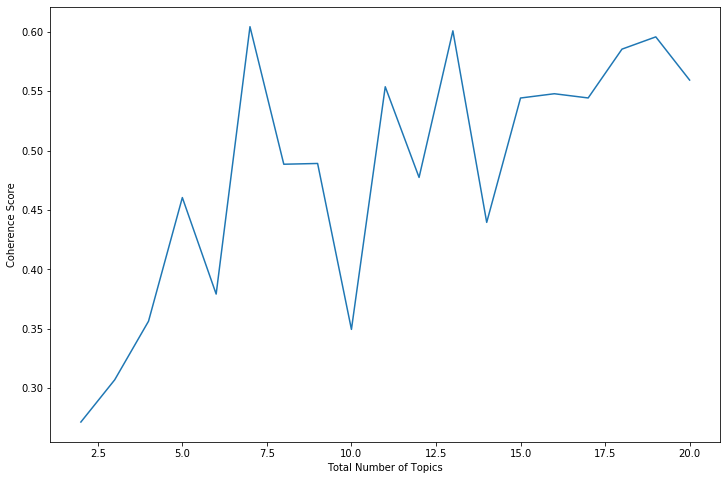

In [89]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=ideal_no_of_topics, y=coherence_scores, ax=ax)
ax.set(xlabel='Total Number of Topics', ylabel='Coherence Score')

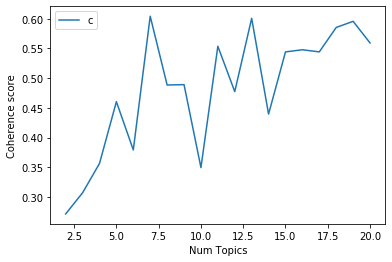

In [86]:
plt.plot(ideal_no_of_topics, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

As we already that the values of coherence increases or improve with the number of topics , we want to limit that keeping complexity and interpretibility in mind . We also observe that the coherence scores or values start to stablize or level out after 13 topics. We could have gone with 20 topic model but that increases complexity and reduces interpretibilty although 20 topics have a better coherence score. We have also seen that 15 topic model has some level of duplication , so choosing a 13 topic LDA model would be a good choice because it may not have any duplication.



# 13-Topic Model

In [90]:
%time ldamodel = Lda(doc_term_matrix, num_topics=13, id2word = dictionary, passes=50)
print(*ldamodel.print_topics(num_topics=13, num_words=5), sep='\n')

CPU times: user 32.8 s, sys: 208 ms, total: 33 s
Wall time: 8.33 s
(0, '0.040*"market" + 0.026*"plant" + 0.015*"case" + 0.011*"industry" + 0.010*"report"')
(1, '0.015*"blade" + 0.013*"company" + 0.012*"pusher" + 0.012*"health" + 0.011*"snow"')
(2, '0.014*"2018" + 0.013*"et" + 0.011*"jan" + 0.011*"manufacturing" + 0.008*"am"')
(3, '0.014*"tax" + 0.010*"u" + 0.008*"city" + 0.006*"median" + 0.006*"china"')
(4, '0.010*"forklift" + 0.009*"year" + 0.005*"bucket" + 0.005*"equipment" + 0.005*"truck"')
(5, '0.022*"sphere" + 0.021*"amazon" + 0.020*"seattle" + 0.012*"monday" + 0.011*"grand"')
(6, '0.008*"caterpillar" + 0.006*"canna" + 0.006*"post" + 0.004*"gas" + 0.004*"new"')
(7, '0.008*"power" + 0.007*"cutting" + 0.006*"torch" + 0.005*"cut" + 0.005*"crane"')
(8, '0.014*"house" + 0.005*"like" + 0.005*"program" + 0.005*"support" + 0.005*"local"')
(9, '0.024*"inc" + 0.015*"jan" + 0.009*"corp" + 0.008*"dec" + 0.007*"nov"')
(10, '0.015*"iot" + 0.010*"mnubo" + 0.007*"data" + 0.007*"company" + 0.007*"

In [91]:
print(*ldamodel.print_topics(num_topics=13, num_words=10), sep='\n')

(0, '0.040*"market" + 0.026*"plant" + 0.015*"case" + 0.011*"industry" + 0.010*"report" + 0.009*"analysis" + 0.009*"growth" + 0.008*"wardian" + 0.008*"terrarium" + 0.008*"also"')
(1, '0.015*"blade" + 0.013*"company" + 0.012*"pusher" + 0.012*"health" + 0.011*"snow" + 0.010*"skid" + 0.010*"rubber" + 0.009*"new" + 0.009*"employee" + 0.009*"panel"')
(2, '0.014*"2018" + 0.013*"et" + 0.011*"jan" + 0.011*"manufacturing" + 0.008*"am" + 0.008*"pm" + 0.007*"caterpillar" + 0.007*"work" + 0.007*"2017" + 0.006*"engineering"')
(3, '0.014*"tax" + 0.010*"u" + 0.008*"city" + 0.006*"median" + 0.006*"china" + 0.006*"rate" + 0.006*"university" + 0.006*"estimate" + 0.006*"state" + 0.005*"repatriation"')
(4, '0.010*"forklift" + 0.009*"year" + 0.005*"bucket" + 0.005*"equipment" + 0.005*"truck" + 0.005*"earth" + 0.004*"grapple" + 0.004*"steer" + 0.004*"brush" + 0.004*"new"')
(5, '0.022*"sphere" + 0.021*"amazon" + 0.020*"seattle" + 0.012*"monday" + 0.011*"grand" + 0.011*"opening" + 0.010*"29" + 0.010*"2018" + 0

In [92]:
print(*ldamodel.print_topics(num_topics=13, num_words=13), sep='\n')

(0, '0.040*"market" + 0.026*"plant" + 0.015*"case" + 0.011*"industry" + 0.010*"report" + 0.009*"analysis" + 0.009*"growth" + 0.008*"wardian" + 0.008*"terrarium" + 0.008*"also" + 0.007*"care" + 0.006*"soil" + 0.006*"key"')
(1, '0.015*"blade" + 0.013*"company" + 0.012*"pusher" + 0.012*"health" + 0.011*"snow" + 0.010*"skid" + 0.010*"rubber" + 0.009*"new" + 0.009*"employee" + 0.009*"panel" + 0.008*"plus" + 0.008*"end" + 0.008*"care"')
(2, '0.014*"2018" + 0.013*"et" + 0.011*"jan" + 0.011*"manufacturing" + 0.008*"am" + 0.008*"pm" + 0.007*"caterpillar" + 0.007*"work" + 0.007*"2017" + 0.006*"engineering" + 0.006*"team" + 0.006*"project" + 0.006*"process"')
(3, '0.014*"tax" + 0.010*"u" + 0.008*"city" + 0.006*"median" + 0.006*"china" + 0.006*"rate" + 0.006*"university" + 0.006*"estimate" + 0.006*"state" + 0.005*"repatriation" + 0.005*"2017" + 0.005*"one" + 0.005*"home"')
(4, '0.010*"forklift" + 0.009*"year" + 0.005*"bucket" + 0.005*"equipment" + 0.005*"truck" + 0.005*"earth" + 0.004*"grapple" + 

In [93]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

The 13 topic LDA model looks perfect in terms of interpretibility. The summarization of topics is also accurate with less compelxity. The bubbles or clusters are well spaced with no overlap or duplication of topics. Hence 13 topic model is our final model.